# Desc

Tutaj chciałem zobaczyć feature output tego resneta (outputuje tensor shape=[2048] features), porównać dla obu zdjęć które features będą podobne i potem zobaczyć które piksele w każdym zdjęciu wpłynęły na wartość danego feature w outpucie. Nie za bardzo działa (myślałem że każdy feature będzie encodował jakiś 'koncept' a rozlewają się po całym obrazku)

In [1]:
import torch
from torchvision import models
import numpy as np

from matplotlib import pyplot as plt
import cv2

from utils import load_img,load_image_into_resnet_tensor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]

In [4]:
resnet = models.resnet50(pretrained=True).to(device)
model = ResnetFeatureExtractor(resnet)

/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


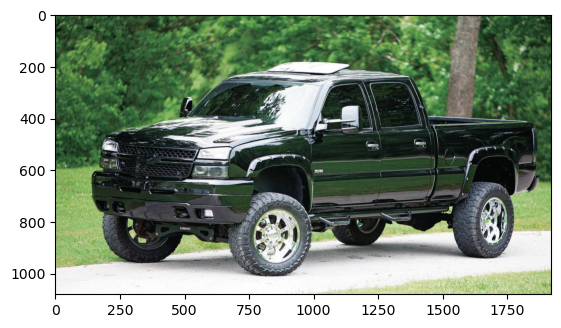

In [5]:
im1 = load_img("/home/milte/Desktop/ainspired/data/test_images/pickup.jpg")

plt.imshow(im1)
plt.show()

In [7]:
im1_tensor = load_image_into_resnet_tensor("/home/milte/Desktop/ainspired/data/test_images/pickup.jpg",device=device)
features = model(im1_tensor)[0]
features.shape

torch.Size([2048])

In [8]:
features_np = features.cpu().detach().numpy()
feature_ids = sorted(np.arange(features_np.shape[0]),reverse=True,key=lambda x: features_np[x])
feature_ids[:5]

[1064, 617, 1189, 666, 2018]

In [9]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget

In [10]:
class FeatureTarget(RawScoresOutputTarget):
    def __init__(self,feature) -> None:
        super().__init__()
        self.feature = feature
    def __call__(self, model_output):
        return model_output[self.feature]

In [11]:
target_layer = [
        #*model.model.layer1,
        #*model.model.layer2,
        #*model.model.layer3,
        model.model.layer4[-1]
        ]
cam = GradCAM(model=model, target_layers=target_layer)

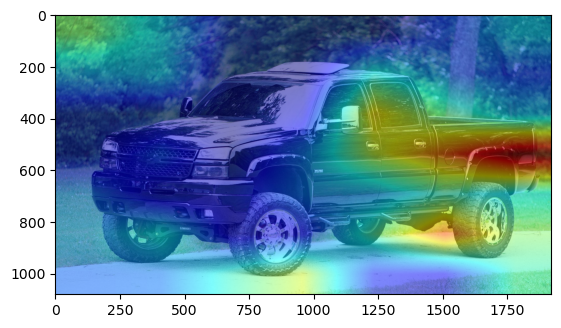

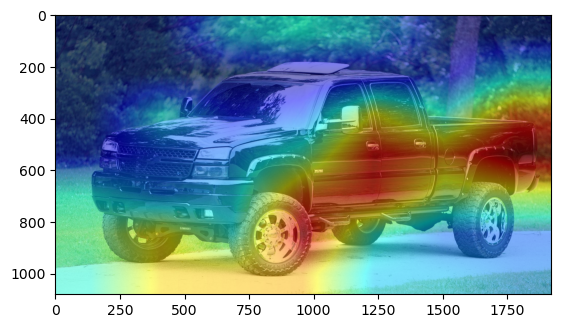

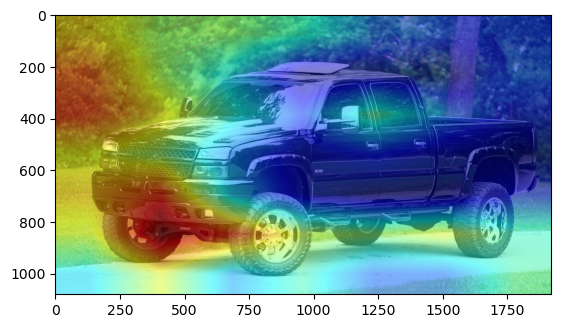

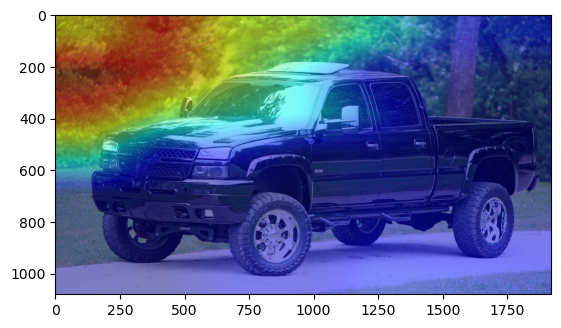

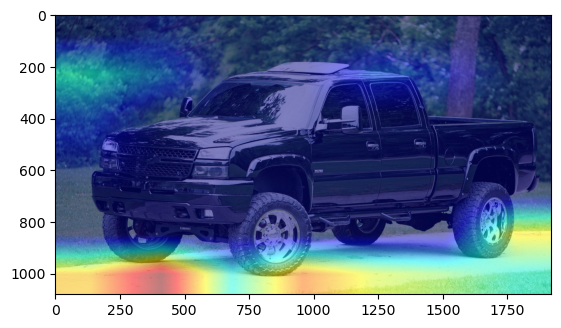

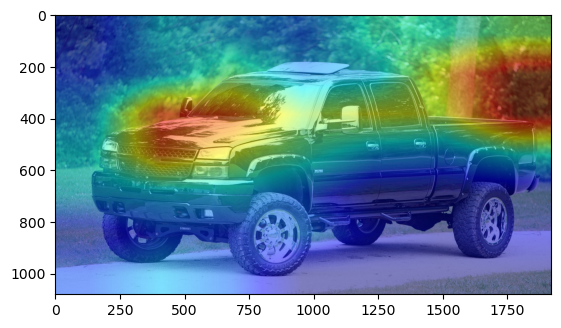

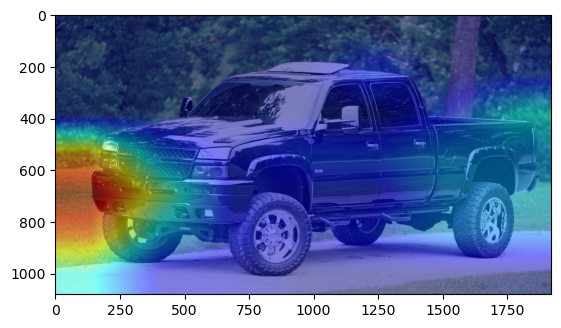

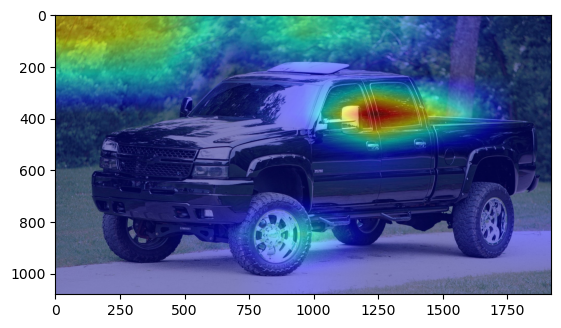

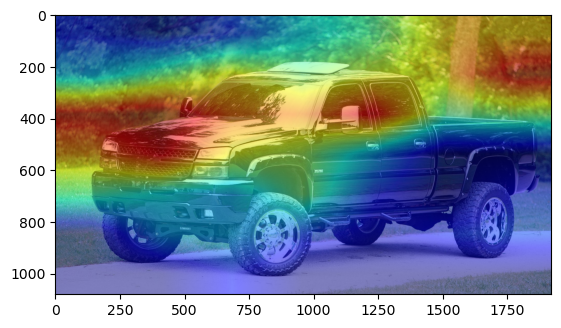

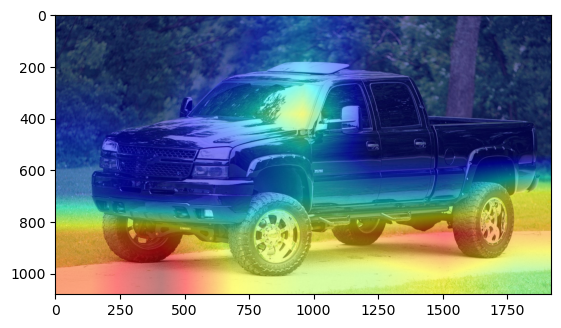

In [12]:
for i in feature_ids[:10]:
    grayscale_cam2 = cam(input_tensor=im1_tensor, targets=[FeatureTarget(i)])
    cam_image = show_cam_on_image(im1, cv2.resize(grayscale_cam2[0],im1.shape[:2][::-1]), use_rgb=True)
    plt.imshow(cam_image)
    plt.show()